### Problem 1 - Gradient Descent and Convergence Rate

1. The gradient descent updates with leaning rate epsilon :  $w^{(t+1)} = w^{(t)} - \epsilon \Phi (\Phi^T w^{(t)} - y)$.
2. Lamda max represents the largest eigenvalue of Hessian matrix and the convergence of gradient descent is guaranteed when epsilon (assume learning rate) is less than 2/lamda max. The Hessian for the loss is $H=\Phi \Phi^T $



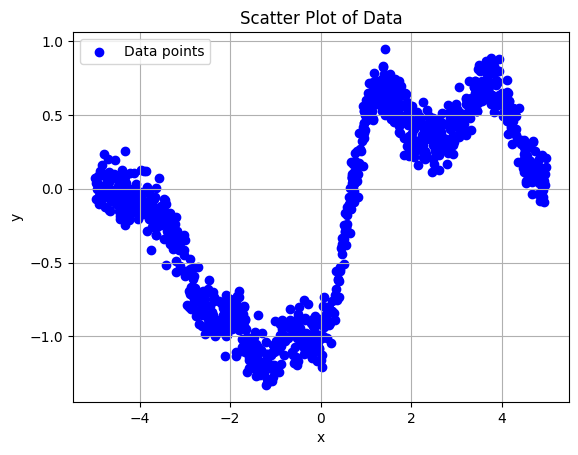

In [9]:
#Always visualize data
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.load("hw1_p1.npy")
x, y = data[:, 0], data[:, 1]

# Visualize the data
plt.scatter(x, y, color='blue', label="Data points")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter Plot of Data")
plt.grid(True)
plt.legend()
plt.show()


In [10]:
# Define Gaussian basis functions
def gaussian_basis(x, centers, sigma=0.25):
    
    return np.exp(-((x[:, None] - centers[None, :]) ** 2) / (2 * sigma ** 2))

# Define centers and create the feature matrix
M = 7
centers = np.array([1.25 * m - 3.75 for m in range(M)])
sigma = 0.25

Phi = gaussian_basis(x, centers, sigma)

# Verify Phi dimensions
print(f"Feature matrix Phi shape:", Phi.shape)


Feature matrix Phi shape: (1000, 7)


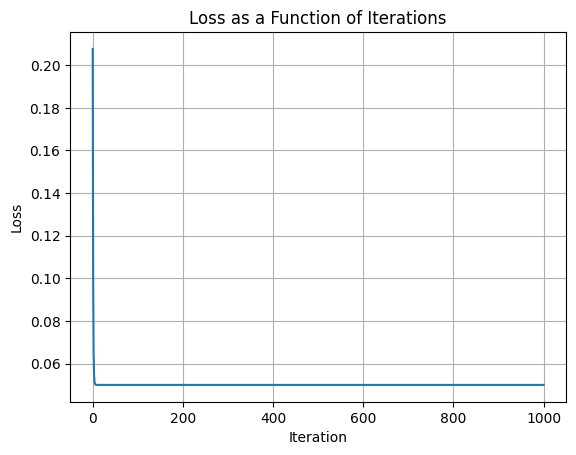

In [11]:
# Mean Squared Error loss
def mse_loss(Phi, w, y):

    residuals = Phi @ w - y
    return 0.5 * np.mean(residuals ** 2)

# Gradient descent implementation
def gradient_descent(Phi, y, w_init, epsilon, num_steps):
    
    w = w_init
    w_history = [w.copy()]
    loss_history = [mse_loss(Phi, w, y)]

    for step in range(num_steps):
        
        gradient = Phi.T @ (Phi @ w - y)

        w = w - epsilon * gradient

        w_history.append(w.copy())
        loss_history.append(mse_loss(Phi, w, y))

    return w_history, loss_history

# Initialize weights
w_init = np.zeros(Phi.shape[1])
epsilon = 0.01
num_steps = 1000

# Run gradient descent
w_history, loss_history = gradient_descent(Phi, y, w_init, epsilon, num_steps)

# Plot the loss over iterations
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss as a Function of Iterations")
plt.grid(True)
plt.show()


### Reflection on the chart
* In above chart, we can observe that the lost function starts relatively high in the first itaretion but quickly decreases within the first steps, showing rapid progress towards the optimal solution.

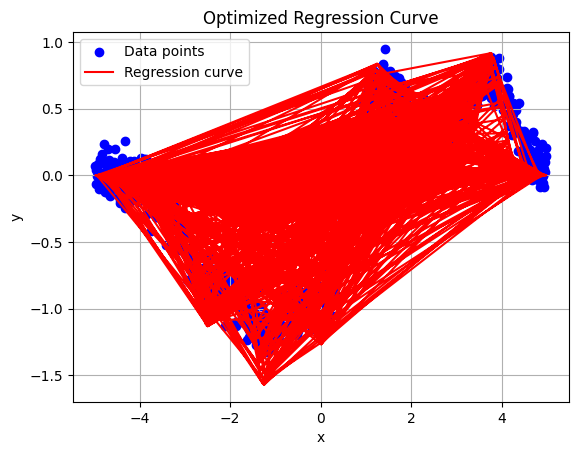

In [12]:
# Optimized weights
w_opt = w_history[-1]

# Compute predictions
y_pred = Phi @ w_opt

# Plot the data and regression curve
plt.scatter(x, y, color='blue', label="Data points")
plt.plot(x, y_pred, color='red', label="Regression curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Optimized Regression Curve")
plt.grid(True)
plt.show()


### Reflection on the chart
* Red lines, which dipict the predicted regression curves using Gaussian, fail to follow smoothly the data points, blue points. Potential issues with that are function selection, learning rate or over/underfitting. From the tangled nature of those red lines, one can say that there is poor convergence or I can say that there is inadequate learning rate such that learning rate is likely high or low relative to the theoritical upper bounding.

In [13]:
# Compute Hessian matrix
H = Phi.T @ Phi  # Hessian is Phi^T Phi

# Eigenvalues of the Hessian
eigenvalues = np.linalg.eigvals(H)
lambda_max = np.max(eigenvalues)  # Maximum eigenvalue
epsilon_upper_bound = 2 / lambda_max

print("Maximum eigenvalue of the Hessian:", lambda_max)
print("Theoretical upper bound for learning rate:", epsilon_upper_bound)


Maximum eigenvalue of the Hessian: 51.92017161633833
Theoretical upper bound for learning rate: 0.03852067390645212


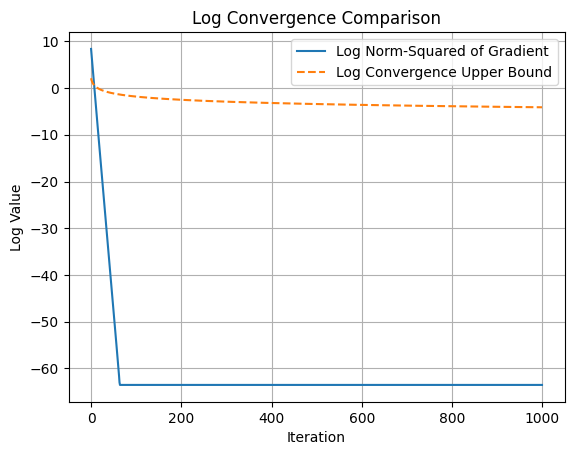

In [14]:
# Compute gradient norms
gradient_norms = [np.linalg.norm(Phi.T @ (Phi @ w - y)) ** 2 for w in w_history]

# Theoretical convergence bound
convergence_bound = [
    2 * lambda_max * (loss_history[0] - loss_history[-1]) / (t + 1)
    for t in range(1, len(loss_history))
]

# Logarithmic convergence plot
plt.plot(np.log(gradient_norms[1:]), label="Log Norm-Squared of Gradient")
plt.plot(np.log(convergence_bound), label="Log Convergence Upper Bound", linestyle="--")
plt.xlabel("Iteration")
plt.ylabel("Log Value")
plt.legend()
plt.title("Log Convergence Comparison")
plt.grid(True)
plt.show()


### Reflection on the chart

The blue line consistantly stays below the orange dashed line. It means that leaning rate, epsilon, adheres to the theoretical constraints. It ensures stability and convergence. The norm squared gradient approaches a very small value near iteration 200. After that it stablizes. 

### Problem 2

1. Here is my smallest MLP architecture: Input Layer (featuresOfX) + Hidden Layer (minimum#OfNeurons) + Output Layer (oneNeuronWithSigmoidActivation). Sigmoid Activation is used in both Hidden and Output Layers. Weights and baises are randomly initialized.

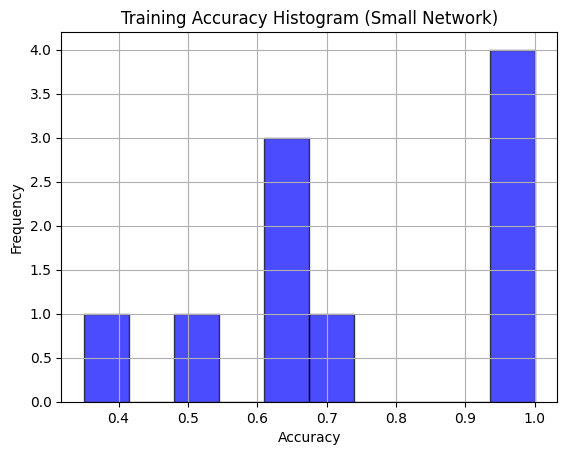

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
data = np.load('hw1_p2.npy')
X, y = data[:, :2], data[:, 2]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the MLP class
class SimpleMLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.W1 = np.random.randn(input_dim, hidden_dim)
        self.b1 = np.zeros(hidden_dim)                    
        self.W2 = np.random.randn(hidden_dim, output_dim) 
        self.b2 = np.zeros(output_dim)                    

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, y_pred, learning_rate):
        m = X.shape[0]
        dz2 = y_pred - y.reshape(-1, 1)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0) / m

        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_derivative(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0) / m

        # Update weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, X, y, epochs=1000, learning_rate=0.1):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            self.backward(X, y, y_pred, learning_rate)

    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

# Train and evaluate the model on 10 runs
accuracies = []
for run in range(10):
    np.random.seed(run)
    mlp = SimpleMLP(input_dim=2, hidden_dim=2, output_dim=1)
    mlp.train(X_train, y_train, epochs=1000, learning_rate=0.1)
    
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot histogram of accuracies
plt.hist(accuracies, bins=10, color='blue', edgecolor='black', alpha=0.7)
plt.title('Training Accuracy Histogram (Small Network)')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Reflection on the chart

The histogram of training accuracies suggests that with a small network size, the model fails to find a consistent solution across all runs. This inconsistency might be due to insufficient capacity or poor weight initialization in the minimal network. My analysis is that smaller network size has probabily insufficient capacity to campture complex functions or patterns in the data.

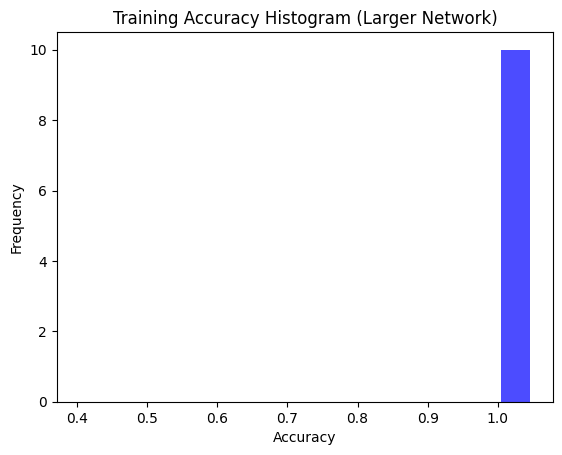

In [23]:
# Experiment: Train larger network (hidden size = 10 neurons) for 10 runs
hidden_size = 10
input_size = X_train.shape[1]
output_size = 1
epochs = 1000
learning_rate = 0.1

accuracies = []
for _ in range(10):
    # Convert y to column vector
    y_train_reshaped = y_train.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)

    # Initialize and train MLP
    mlp = MLP(input_size, hidden_size, output_size)
    mlp.train(X_train, y_train_reshaped, epochs, learning_rate)
    
    # Evaluate on test set
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test_reshaped, y_pred)
    accuracies.append(acc)

# Plot histogram of accuracies
plt.hist(accuracies, bins=np.arange(0.4, 1.1, 0.05), color='blue', alpha=0.7, rwidth=0.85)
plt.title("Training Accuracy Histogram (Larger Network)")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()


### Reflection on the chart

In contrast, for the larger network, the histogram demonstrates perfect training accuracy (1.0) for all 10 runs. This indicates that increasing the hidden layer size provides sufficient capacity to model the data successfully. The larger network is also more robust to weight initialization variability.

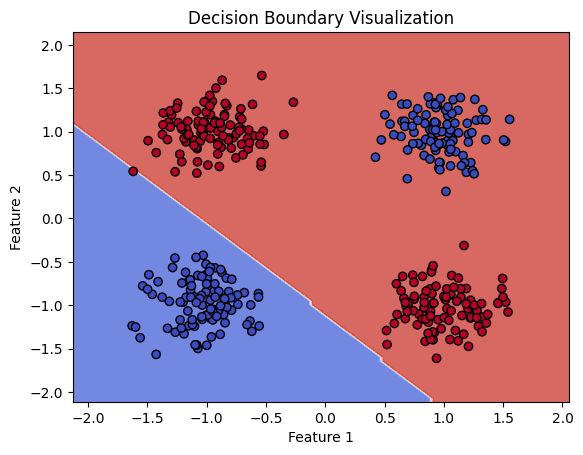

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Example of assigning model parameters
model = {
    'W1': np.random.rand(2, hidden_size),
    'W2': np.random.rand(hidden_size, 1),
    'b1': np.random.rand(hidden_size),    
    'b2': np.random.rand(1)               
}


# Generate a grid of points spanning the dataset range
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Flatten the grid and prepare input
grid = np.c_[xx.ravel(), yy.ravel()]

# Compute predictions for the grid points
predictions = []
for pt in grid:
    z1 = np.dot(pt, model['W1']) + model['b1']
    h = np.tanh(z1)
    z2 = np.dot(h, model['W2']) + model['b2']
    predictions.append(1 if z2 > 0 else 0)

predictions = np.array(predictions).reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, predictions, alpha=0.8, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
plt.title('Decision Boundary Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### Reflection on the chart

The chart visualize the the decision boundary learned by the model which uses a simple forward pass, with fixed model prameters. It shows how well the model seperates the space into different classes such as 0 and 1.

Epoch 0, Loss: 1.0116
Epoch 100, Loss: 0.1475
Epoch 200, Loss: 0.0706
Epoch 300, Loss: 0.0456
Epoch 400, Loss: 0.0335
Epoch 500, Loss: 0.0264
Epoch 600, Loss: 0.0218
Epoch 700, Loss: 0.0185
Epoch 800, Loss: 0.0160
Epoch 900, Loss: 0.0141


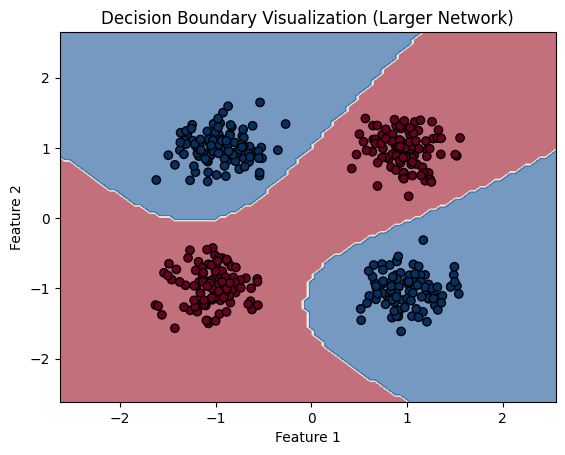

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to initialize a larger network
def initialize_model_large():
    input_dim = 2  
    hidden_dim = 10
    output_dim = 1 
    np.random.seed(42)
    
    # Random weight and bias initialization
    model = {
        "W1": np.random.randn(input_dim, hidden_dim),
        "b1": np.random.randn(hidden_dim),
        "W2": np.random.randn(hidden_dim, output_dim),
        "b2": np.random.randn(output_dim)
    }
    return model

# Function to compute forward pass
def forward_pass_large(X, model):
    z1 = np.dot(X, model['W1']) + model['b1']
    h = np.tanh(z1) 
    z2 = np.dot(h, model['W2']) + model['b2']
    y_pred = 1 / (1 + np.exp(-z2))  
    return y_pred, h

# Function for gradient descent with updated model
def train_model_large(X_train, y_train, model, learning_rate=0.1, epochs=1000):
    for epoch in range(epochs):
        y_pred, h = forward_pass_large(X_train, model)
        
        loss = -(y_train * np.log(y_pred) + (1 - y_train) * np.log(1 - y_pred)).mean()
   
        dz2 = y_pred - y_train
        dW2 = np.dot(h.T, dz2) / X_train.shape[0]
        db2 = np.sum(dz2, axis=0) / X_train.shape[0]
        
        dh = np.dot(dz2, model['W2'].T)
        dz1 = dh * (1 - h ** 2)  # Derivative of tanh
        dW1 = np.dot(X_train.T, dz1) / X_train.shape[0]
        db1 = np.sum(dz1, axis=0) / X_train.shape[0]
        
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    return model

# Function to plot decision boundary
def plot_decision_boundary_large(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    y_pred, _ = forward_pass_large(grid, model)
    y_pred = (y_pred > 0.5).astype(int)
    y_pred = y_pred.reshape(xx.shape)
    
    plt.contourf(xx, yy, y_pred, alpha=0.6, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolor="k", cmap=plt.cm.RdBu)
    plt.title("Decision Boundary Visualization (Larger Network)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Load your data
data = np.load('hw1_p2.npy', allow_pickle=True)
X, y = data[:, :2], data[:, 2:]
y = y.reshape(-1, 1)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the larger model
model_large = initialize_model_large()
model_large = train_model_large(X_train, y_train, model_large)

# Plot the decision boundary for the larger network
plot_decision_boundary_large(X, y, model_large)


### Reflection on the chart



### Problem 3

In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load Data (10 datasets from 'hw1 p3.npy' and 'hw1 p3 gt.npy')
X = np.load('hw1_p3.npy')   # Data for 10 sets
y_gt = np.load('hw1_p3_gt.npy')  # Ground truth data for each set

# Parameters for the basis functions
M = 7  # Number of basis functions

# Define the mu and s as provided
mu = torch.linspace(-5, 5, M+2)[1:-1]
s = 2 / (M + 1)

# Gaussian basis functions for each observation (assuming X is the input data)
def basis_functions(x):
    phi_x = torch.exp(-0.5 * ((x - mu) / s)**2)
    return phi_x

# Create feature matrix for each data observation
def create_feature_matrix(X):
    features = np.array([basis_functions(torch.tensor(x)).numpy() for x in X])
    return features

# Solve the regression for each of the 10 datasets (y = Phi * w)
def solve_regression(X, y):
    Phi = create_feature_matrix(X)
    # Closed form solution for weights (w = (Phi^T * Phi)^-1 * Phi^T * y)
    w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ y
    return w

# Solve for weights for each of the 10 data sets and store the predictions
f_preds = []
for i in range(10):
    y = y_gt[i]  # Get the actual data for this observation
    w = solve_regression(X[i], y)  # Solve for weights using the closed form
    f_i = create_feature_matrix(X[i]) @ w  # Predicted values
    f_preds.append(f_i)

f_preds = np.array(f_preds)

# Plot fi vs f_star for each of the 10 observations
f_star = y_gt.mean(axis=0)  # Mean of ground truth
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.ravel()

for i in range(10):
    axes[i].plot(X[i], f_preds[i], label=f"f{i} (Predicted)")
    axes[i].plot(X[i], y_gt[i], label="f*(Ground Truth)", linestyle='--')
    axes[i].set_title(f"Observation {i+1}")
    axes[i].legend()

plt.tight_layout()
plt.show()


AttributeError: module 'torch' has no attribute 'linspace'

In [66]:
print(f"Shape of f_preds: {np.array(f_preds).shape}")
print(f"Shape of f_star: {f_star.shape}")


Shape of f_preds: (10, 100)
Shape of f_star: (2, 1000)


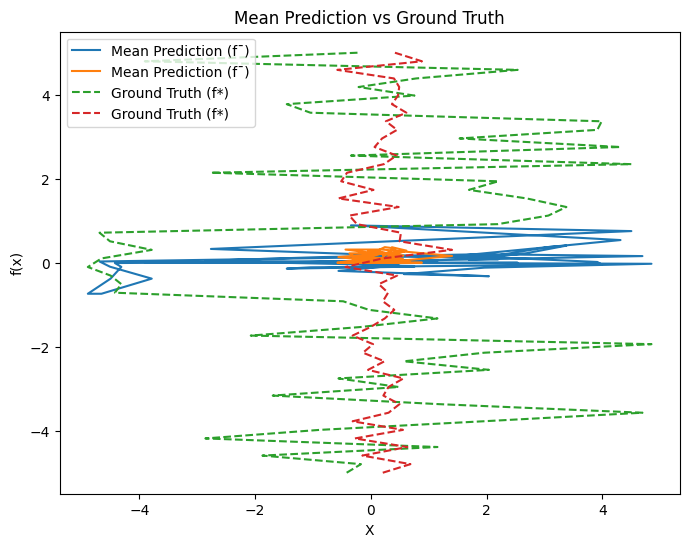

In [75]:
f_mean = np.mean(f_preds, axis=0)  # Mean of predictions across all datasets

# Plot the mean prediction against the ground truth
plt.figure(figsize=(8, 6))
plt.plot(X[0], f_mean, label="Mean Prediction (f¯)")
plt.plot(X[0], f_star, label="Ground Truth (f*)", linestyle='--')
plt.legend()
plt.title('Mean Prediction vs Ground Truth')
plt.xlabel('X')
plt.ylabel('f(x)')
plt.show()


In [78]:
# Calculate Bias and Variance after checking shapes
f_mean = np.mean(f_preds, axis=0)  # Mean prediction across the 10 datasets

# Ensure f_star is a 1D array of shape (50,)
f_star = np.mean(y_gt, axis=0)  # Assuming y_gt represents the true ground truth

# Calculate Bias and Variance
bias = np.mean((f_preds - f_star)**2)
variance = np.mean((f_preds - f_mean)**2)

print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")


ValueError: operands could not be broadcast together with shapes (10,50,2) (1000,) 